### Converting Aeronet Lw to Rrs
##### 1. Load in Packages and Aeronet

In [2]:
#Load in packages
import os
import numpy as np
import math
import pandas as pd
import scipy.io as sp
import matplotlib.pyplot as plt
import warnings
import xarray as xr
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load in aeronet file (TSM) from insitu directory
df_aero = pd.read_csv('/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/Aeronet_TSM.dat', delim_whitespace=True, header=None, names=['date', 'TSM'])
df_aero['date'] = pd.to_datetime(df_aero['date'], format='%d-%b-%Y')

#display contents
print(f"---- Aeronet File ----")
df_aero.head()

---- Aeronet File ----


,date,TSM
0,2021-10-07,7.1570
1,2021-10-16,6.2503
2,2021-10-17,10.7708
3,2021-10-18,11.0370
4,2021-10-20,7.4549


#### Calculate TSM from aeronet

In [3]:
df_aero_SLS = pd.read_csv('/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/Old versions/aeronet_CB_2021_2024_15_oct2024.csv', usecols=['Date(dd-mm-yyyy)','Time(hh:mm:ss)','Lwn[620nm]','Lwn[667nm]'])
df_aero_SLS.head()
#Get 645 thru interp
df_aero_SLS['nLw_645'] = df_aero_SLS['Lwn[620nm]'] + ((645 - 620) / (667 - 620)) * (df_aero_SLS['Lwn[667nm]'] - df_aero_SLS['Lwn[620nm]'])
#Calculate TSM
def getTSM(df):
    df['TSM'] = (3.8813 * (df['nLw_645'] ** 3) - 13.822 * (df['nLw_645'] ** 2) + 19.61 * df['nLw_645'])
    return(df)
df_aero = getTSM(df_aero_SLS)
df_aero['date'] = pd.to_datetime(df_aero['Date(dd-mm-yyyy)'], format="%d:%m:%Y")
df_aero.head()

,Date(dd-mm-yyyy),Time(hh:mm:ss),Lwn[620nm],Lwn[667nm],nLw_645,TSM,date
0,07:10:2021,1:25:38 PM,0.668019,0.424317,0.538390,7.157048,2021-10-07
1,16:10:2021,2:10:02 PM,0.444647,0.429569,0.436627,6.250263,2021-10-16
2,17:10:2021,3:26:04 PM,1.562836,1.129445,1.332309,10.770806,2021-10-17
3,18:10:2021,2:10:55 PM,1.641064,1.199826,1.406363,11.037005,2021-10-18
4,20:10:2021,2:08:36 PM,0.669060,0.495002,0.576476,7.454872,2021-10-20


In [4]:
df_aero['nLw_645'].min()

0.13458906382978725

#### Crop to relevant columns

In [5]:
#format datetime
df_aero['datetime'] = pd.to_datetime(df_aero['date'].dt.strftime('%Y-%m-%d')  + ' ' + df_aero['Time(hh:mm:ss)'])
df_aero.head()

,Date(dd-mm-yyyy),Time(hh:mm:ss),Lwn[620nm],Lwn[667nm],nLw_645,TSM,date,datetime
0,07:10:2021,1:25:38 PM,0.668019,0.424317,0.538390,7.157048,2021-10-07,2021-10-07 13:25:38
1,16:10:2021,2:10:02 PM,0.444647,0.429569,0.436627,6.250263,2021-10-16,2021-10-16 14:10:02
2,17:10:2021,3:26:04 PM,1.562836,1.129445,1.332309,10.770806,2021-10-17,2021-10-17 15:26:04
3,18:10:2021,2:10:55 PM,1.641064,1.199826,1.406363,11.037005,2021-10-18,2021-10-18 14:10:55
4,20:10:2021,2:08:36 PM,0.669060,0.495002,0.576476,7.454872,2021-10-20,2021-10-20 14:08:36


#### Format the stream gauge data

In [6]:
#LOAD IN STREAM DATA
def writeStreamData(dfMatchups):
    df_stream = pd.read_csv('/panfs/ccds02/nobackup/people/slsmit34/Insitu/USGS_streamGauge/SQ_2021_2024.csv') #load in df_aero
    df_stream['date'] = pd.to_datetime(df_stream['datetime']) #Include year
    df_stream = df_stream.loc[:, ['date', '68118_00060_00003']]
    dfMatchups['date'] = pd.to_datetime(dfMatchups[['year', 'month', 'days']])
    dfMatchups = pd.merge(dfMatchups, df_stream, on='date', how='left')  # Merge df2 and df1 based on the 'date' column
    dfMatchups['stream gauge'] = dfMatchups['68118_00060_00003']
    return(dfMatchups)
df_stream = pd.read_csv('/panfs/ccds02/nobackup/people/slsmit34/Insitu/USGS_streamGauge/SQ_2021_2024.csv') #load in df_aero
df_stream['date'] = pd.to_datetime(df_stream['datetime']) #Include year
df_stream = df_stream.loc[:, ['date', '68118_00060_00003']]

In [7]:
df_height = pd.read_csv('/panfs/ccds02/nobackup/people/slsmit34/Insitu/USGS_streamGauge/SQ_gaugeHeight_2022_2025.csv') #load in df_aero
df_height['date'] = pd.to_datetime(df_height['datetime']) #Include year
df_height.head()

,agency_cd,site_no,datetime,tz_cd,69543_00065,69543_00065_cd,date
0,USGS,1578310,5/31/2022 23:00,EDT,13.52,A,2022-05-31 23:00:00
1,USGS,1578310,5/31/2022 23:15,EDT,12.90,A,2022-05-31 23:15:00
2,USGS,1578310,5/31/2022 23:30,EDT,11.79,A,2022-05-31 23:30:00
3,USGS,1578310,5/31/2022 23:45,EDT,10.91,A,2022-05-31 23:45:00
4,USGS,1578310,6/1/2022 0:00,EDT,10.40,A,2022-06-01 00:00:00


In [8]:
brackets = [20, 21.5, 22.9, 23.7, 24.8, 26.3]
def cropDsToHeight(df_height, heightMin, heightMax):
    df = df_height[df_height['69543_00065'] >= heightMin]
    df = df[df['69543_00065'] < heightMax]
    return(df)
#-----
df20 = cropDsToHeight(df_height, 20, 21.5)# Open 2 gates
df21_5 = cropDsToHeight(df_height, 21.5, 26.3)# 4 gates total open
#df22_9 = cropDsToHeight(df_height,  22.9, 23.7)#Close Rt 222
#df23_7 = cropDsToHeight(df_height,  23.7, 24.8)#Minor flooding
#df24_8 = cropDsToHeight(df_height, 24.8, 26.3)#Backyards flood
df26_3 = cropDsToHeight(df_height, 26.3, 30)# 6 gates total open

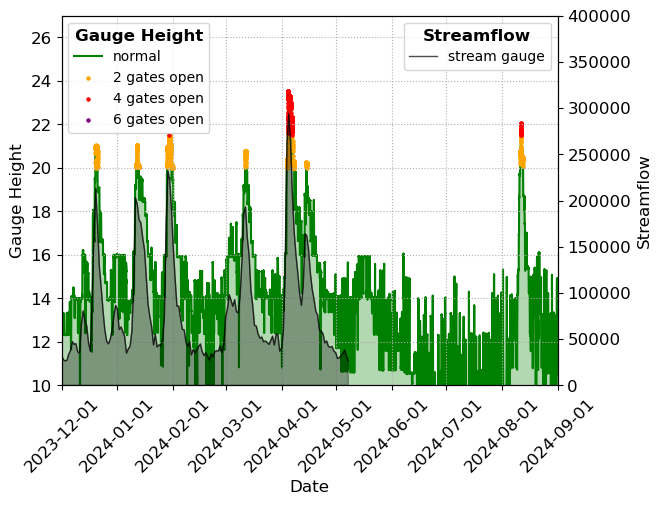

In [9]:
import matplotlib.dates as mdates
fig, ax1 = plt.subplots() 
#Add stream gauge data
ax2 = ax1.twinx()  # Create a second y-axis
#plot stream gauge
ax2.plot(df_stream['date'], df_stream['68118_00060_00003'], color='black', alpha = .7,lw=1, label = 'stream gauge')  # Plot stream gauge data on the second y-axis
ax2.fill_between(df_stream['date'], df_stream['68118_00060_00003'], color='black', alpha=0.3, zorder = 0)

#plot height
ax1.plot(df_height['date'], df_height['69543_00065'], c = 'green',  alpha = 1,zorder = 0, label = 'normal')
ax1.fill_between(df_height['date'], df_height['69543_00065'], color='green', alpha=0.3, zorder = 0)

#add gate openings
ax1.scatter(df20['date'], df20['69543_00065'], lw = .5, s = 7, c = 'orange', label = '2 gates open')
ax1.scatter(df21_5['date'], df21_5['69543_00065'], lw = .5, s = 7, c = 'red', label = '4 gates open')
ax1.scatter(df26_3['date'], df26_3['69543_00065'], lw = .5, s = 7, c = 'purple', label = '6 gates open')


ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
#Set title font
from matplotlib.font_manager import FontProperties

# Create font properties 
title_font = FontProperties()
title_font.set_size(12)          
title_font.set_weight('bold')    


ax1_legend = ax1.legend(loc='upper left', fontsize=10, title="Gauge Height")
ax2_legend = ax2.legend(loc='upper right', fontsize = 10, title = "Streamflow")
ax2_legend.get_title().set_fontproperties(title_font)
ax1_legend.get_title().set_fontproperties(title_font)

ax1.set_ylabel('Gauge Height', fontsize =12)
ax2.set_ylabel('Streamflow', fontsize = 12)
#plt.title('TSM readings at Aeronet and SQ Sites', fontsize = 14)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlim(pd.to_datetime('2023-12-01'),pd.to_datetime('2024-09-01'))
ax1.set_ylim(10,27)
ax2.set_ylim(0,400000)
ax1.set_xlabel("Date", fontsize = 12)
#
plt.show()

In [10]:
df21_5
print('\n--2 gates open:')
for date in df20['date'].dt.date.unique():
    print(date)
print('\n--4 gates open:')
for date in df21_5['date'].dt.date.unique():
    print(date)


--2 gates open:
2023-05-02
2023-05-03
2023-12-19
2023-12-20
2024-01-11
2024-01-12
2024-01-28
2024-01-29
2024-01-30
2024-01-31
2024-03-11
2024-03-12
2024-04-03
2024-04-04
2024-04-07
2024-04-08
2024-04-14
2024-08-11
2024-08-12

--4 gates open:
2024-01-29
2024-04-04
2024-04-05
2024-04-06
2024-04-07
2024-08-11


#### Format the satellite data

In [52]:
dfSQ =  pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/jan2025_rerun_matchups/bulk_Aero_OLCI_combined_with_datetime_CW.csv')
sq_lat,sq_lon = 39.62945431444071, -76.15412278985237
dfSQ['latitude'] = sq_lat
dfSQ['longitude'] = sq_lon

dfAE =  pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/marglint2025_rerun_matchups/bulk_Aero_OLCI_combined_with_datetime.csv')
ae_lat,ae_lon = 39.12351, -76.34890
dfAE['latitude'] = ae_lat
dfAE['longitude'] = ae_lon

dfAE

,Unnamed: 0,Rrs_400,Rrs_412,Rrs_443,Rrs_490,Rrs_510,Rrs_560,Rrs_620,Rrs_665,Rrs_674,...,Rrs_709,fn,date,percentValids(flagged/unflagged),datetime,time_str,datetime_utc,datetime_est,latitude,longitude
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,S3A_OLCI_EFRNT.20210101T152649.L2.OC.nc,01:01:2021,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/...",2021-01-01,152649,2021-01-01 15:26:49,2021-01-01 15:26:49,39.12351,-76.3489
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,S3A_OLCI_EFRNT.20210102T150038.L2.OC.nc,02:01:2021,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/...",2021-01-02,150038,2021-01-02 15:00:38,2021-01-02 15:00:38,39.12351,-76.3489
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,S3A_OLCI_EFRNT.20210104T154916.L2.OC.nc,04:01:2021,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/...",2021-01-04,154916,2021-01-04 15:49:16,2021-01-04 15:49:16,39.12351,-76.3489
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,S3A_OLCI_EFRNT.20210105T152305.L2.OC.nc,05:01:2021,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/...",2021-01-05,152305,2021-01-05 15:23:05,2021-01-05 15:23:05,39.12351,-76.3489
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,S3A_OLCI_EFRNT.20210106T145655.L2.OC.nc,06:01:2021,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/...",2021-01-06,145655,2021-01-06 14:56:55,2021-01-06 14:56:55,39.12351,-76.3489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,S3B_OLCI_EFRNT.20241225T145146.L2.OC.nc,25:12:2024,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/...",2024-12-25,145146,2024-12-25 14:51:46,2024-12-25 14:51:46,39.12351,-76.3489
1767,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,S3B_OLCI_EFRNT.20241227T154023.L2.OC.nc,27:12:2024,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/...",2024-12-27,154023,2024-12-27 15:40:23,2024-12-27 15:40:23,39.12351,-76.3489
1768,215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,S3B_OLCI_EFRNT.20241228T151412.L2.OC.nc,28:12:2024,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/...",2024-12-28,151412,2024-12-28 15:14:12,2024-12-28 15:14:12,39.12351,-76.3489
1769,216,0.002670,0.002594,0.003017,0.003546,0.003860,0.005537,0.003294,0.002201,0.002085,...,0.001458,S3B_OLCI_EFRNT.20241231T153638.L2.OC.nc,31:12:2024,"['9/9', '9/9', '9/9', '9/9', '9/9', '9/9', '9/...",2024-12-31,153638,2024-12-31 15:36:38,2024-12-31 15:36:38,39.12351,-76.3489


In [50]:
# Load in Rrs and calc TSM from S3
year = 2024
dfAE_1 = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/Aeronet_matchups/Sentinel-3_OLCI/2024_stormEvent/years/{year}_AE_S3A_ext.csv')
dfSQ_1 =  pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/Aeronet_matchups/Sentinel-3_OLCI/2024_stormEvent/years/{year}_SQ_S3A_ext.csv')

# original
dfSQ_2 = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/Aeronet_matchups/Sentinel-3_OLCI/2024_stormEvent/years/bkup/{year}_SQ_S3A.csv')
dfAE_2 =  pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/Aeronet_matchups/Sentinel-3_OLCI/2024_stormEvent/years/bkup/{year}_AE_S3A.csv')

#original s3b 
dfSQ_3 =  pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/Aeronet_matchups/Sentinel-3_OLCI/2024_stormEvent/years/bkup/{year}_SQ.csv')
dfAE_3 =  pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/Aeronet_matchups/Sentinel-3_OLCI/2024_stormEvent/years/bkup/{year}_AE.csv')

dfAE = pd.concat([dfAE_1, dfAE_2, dfAE_3])
dfSQ = pd.concat([dfSQ_1, dfSQ_2, dfSQ_3])
dfAE

,Unnamed: 0,Rrs_400,Rrs_412,Rrs_443,Rrs_490,Rrs_510,Rrs_560,Rrs_620,Rrs_665,Rrs_674,Rrs_681,l2_flags,longitude,latitude,date,time
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1073742400,-76.350160,39.123140,2024-09-05,15:08:02
1,1,-0.001812,-0.000888,-0.000432,0.000542,0.001122,0.003342,0.002308,0.001664,0.001700,0.002024,2099268,-76.347786,39.123775,2024-09-08,15:30:28
2,2,-0.001168,-0.000584,0.000452,0.001182,0.001650,0.003678,0.002250,0.001458,0.001442,0.001682,13109312,-76.350380,39.122560,2024-09-09,15:04:17
3,3,-0.002250,-0.001374,-0.000124,0.000706,0.001158,0.002928,0.001728,0.001406,0.001362,0.001514,2099268,-76.348200,39.124560,2024-09-12,15:26:45
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1073742400,-76.351616,39.126026,2024-09-13,15:00:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1073742400,-76.349650,39.123170,2024-09-26,15:25:24
159,159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1073742400,-76.348785,39.122234,2024-09-27,14:59:13
160,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1074790976,-76.347800,39.123615,2024-09-29,15:47:49
161,161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1073742400,-76.347880,39.123080,2024-09-30,15:21:38


#### Get TSM from satellite data

In [53]:
#Get TSM - for updated CW dam 
#Extrapolate 645nm
dfAE['Rrs_645'] = dfAE['Rrs_620'] + ((645 - 620) / (665 - 620)) * (dfAE['Rrs_665'] - dfAE['Rrs_620'])
dfSQ['Rrs_645'] = dfSQ['Rrs_620'] + ((645 - 620) / (665 - 620)) * (dfSQ['Rrs_665'] - dfSQ['Rrs_620'])

#F0 = 1528
#From OB.DAAC: (W/m^2/um)
F0_620 = 1649.287
F0_665 = 1530.541

# Wavelengths
lambda_620 = 620
lambda_665 = 665
lambda_target = 645

# Linear interpolation to find F0 at 645 nm
F0 = (F0_620 + ((lambda_target - lambda_620) / (lambda_665 - lambda_620)) * (F0_665 - F0_620))

print("F0 at 645 nm:", F0)

dfAE['nLw_645'] = dfAE['Rrs_645']*F0/10
dfSQ['nLw_645'] = dfSQ['Rrs_645']*F0/10

#Calculate TSM
def getTSM(df):
    df['TSM'] = (3.8813 * (df['nLw_645'] ** 3) - 13.822 * (df['nLw_645'] ** 2) + 19.61 * df['nLw_645'])
    return(df)
dfAE = getTSM(dfAE)
dfSQ = getTSM(dfSQ)
#remove TSM rows
dfAE = dfAE.dropna(subset=['TSM'])
dfSQ = dfSQ.dropna(subset=['TSM'])
dfAE = dfAE.sort_values(by='datetime_est')
dfSQ = dfSQ.sort_values(by='datetime_est')
dfAE.head()

F0 at 645 nm: 1583.317


,Unnamed: 0,Rrs_400,Rrs_412,Rrs_443,Rrs_490,Rrs_510,Rrs_560,Rrs_620,Rrs_665,Rrs_674,...,percentValids(flagged/unflagged),datetime,time_str,datetime_utc,datetime_est,latitude,longitude,Rrs_645,nLw_645,TSM
6,6,0.008084,0.009158,0.010462,0.013014,0.014680,0.020854,0.019249,0.016620,0.016083,...,"['4/6', '4/6', '4/6', '4/6', '4/6', '4/6', '4/...",2021-01-09,151922,2021-01-09 15:19:22,2021-01-09 15:19:22,39.12351,-76.3489,0.017788,2.816431,32.301256
7,7,0.006337,0.007616,0.008127,0.009941,0.011600,0.017209,0.015445,0.013357,0.012863,...,"['9/9', '9/9', '9/9', '9/9', '9/9', '9/9', '9/...",2021-01-10,145311,2021-01-10 14:53:11,2021-01-10 14:53:11,39.12351,-76.3489,0.014285,2.261786,18.553583
894,6,0.007156,0.008141,0.008711,0.010227,0.011372,0.016099,0.013508,0.010725,0.010232,...,"['9/9', '9/9', '9/9', '9/9', '9/9', '9/9', '9/...",2021-01-12,150224,2021-01-12 15:02:24,2021-01-12 15:02:24,39.12351,-76.3489,0.011962,1.893933,13.928382
8,8,0.008379,0.009171,0.010014,0.011791,0.013092,0.017686,0.015295,0.012504,0.011897,...,"['9/9', '9/9', '9/9', '9/9', '9/9', '9/9', '9/...",2021-01-12,154149,2021-01-12 15:41:49,2021-01-12 15:41:49,39.12351,-76.3489,0.013744,2.176174,17.217283
896,8,0.004933,0.005985,0.006309,0.007378,0.008201,0.012709,0.010018,0.007533,0.007066,...,"['9/9', '9/9', '9/9', '9/9', '9/9', '9/9', '9/...",2021-01-16,145839,2021-01-16 14:58:39,2021-01-16 14:58:39,39.12351,-76.3489,0.008637,1.367576,10.894684


#### (***) NEW: Format TSM sensor data (from CBP and Blake)

1. CBP TSM sensors

In [13]:
def load_datFile(loc): 
    df = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Blake_TSM/UpperBay_TSM/{loc}.dat', delim_whitespace=True)#, header=0)
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')
    return(df)

# Load in all files
CB1_1 = load_datFile('CB1.1')
CB2_1 = load_datFile('CB2.1')
CB2_2 = load_datFile('CB2.2')
CB3_1 = load_datFile('CB3.1')
CB3_2 = load_datFile('CB3.2')
CB3_3 = load_datFile('CB3.3C')
CBP_dict = {'CB1.1': CB1_1, 'CB2.1': CB2_1, 'CB2.2': CB2_2, 'CB3.1': CB3_1, 'CB3.2': CB3_2, 'CB3.3': CB3_3}

# Station coords
CBP_coords_raw = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Blake_TSM/StatCoords_UpperCBAY.dat', header=None)

# display contents
print(f"---- CBP TSM measurements ----")
CB1_1.head()

---- CBP TSM measurements ----


,Date,TSM,(mg/L),Depth
0,2020-02-12,11.0,5.0,NaN
1,2020-02-12,12.4,0.5,NaN
2,2020-05-26,13.0,7.0,NaN
3,2020-05-26,4.5,0.5,NaN
4,2020-07-08,3.7,5.0,NaN


In [14]:
#Get the Coordinates of the stations
CBP_coords = pd.DataFrame(columns = ['Location', 'lat', 'lon'])
i = 0
while i < len(CBP_coords_raw):
    x = CBP_coords_raw[0][i].split('        ')
    CBP_coords.loc[len(CBP_coords)] = x
    i = i+1
for index, row in CBP_coords.iterrows():
    CBP_coords['lon'][index] = float(CBP_coords['lon'][index][1:])
    CBP_coords['lat'][index] = float(CBP_coords['lat'][index])
CBP_coords

,Location,lat,lon
0,CB1.1,-76.0848,39.5479
1,CB2.1,-76.026,39.4415
2,CB2.2,-76.1758,39.3487
3,CB3.1,-76.2405,39.2495
4,CB3.2,-76.3063,39.1637
5,CB3.3C,-76.3597,38.996


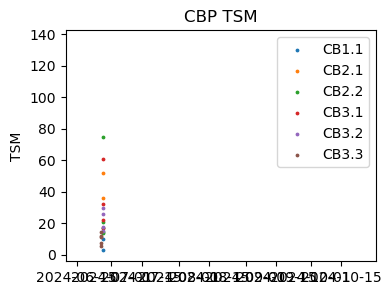

In [15]:
# get time of interest
def plotTSM(key, param):
    df =  CBP_dict[key]
    plt.scatter(df['Date'], df[param], label = key, s = 3)
    return('done')

# Param of interest
param = 'TSM'

# Make the plot
plt.figure(figsize=(4,3))        
for CBP_key in CBP_dict: plotTSM(CBP_key, param)
plt.ylabel(param)
plt.title('CBP TSM')
plt.legend()

plt.xlim(pd.to_datetime('6-10-2024'),pd.to_datetime('10-31-2024'))
plt.show()

In [16]:
#Get date of interest
startDate ='1-20-2024'
endDate = '2-20-2024'
halfProc = CB1_1[CB1_1['Date'] > startDate]
fullProc = halfProc[halfProc['Date'] < endDate]
print(fullProc['Date'])
DOI = pd.to_datetime(fullProc['Date'].iloc[0])
DOI

102   2024-01-25
103   2024-01-25
Name: Date, dtype: datetime64[ns]


Timestamp('2024-01-25 00:00:00')

In [11]:
date = '01-21'
date2 = '01-22'
olciScene = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Sentinel-3_OLCI/storm_personalUse/composites/2024-{date}_2024-{date2}.nc'
print(olciScene)
ds = xr.open_dataset(olciScene)
ds

/panfs/ccds02/nobackup/people/slsmit34/Satellite/Sentinel-3_OLCI/storm_personalUse/composites/2024-01-21_2024-01-22.nc


<xarray.Dataset> Size: 17MB
Dimensions:    (latitude: 720, longitude: 749)
Coordinates:
  * latitude   (latitude) float64 6kB 38.92 38.92 38.92 ... 39.63 39.63 39.63
  * longitude  (longitude) float64 6kB -76.63 -76.63 -76.63 ... -75.89 -75.88
Data variables:
    Rrs_412    (latitude, longitude) float32 2MB ...
    Rrs_443    (latitude, longitude) float32 2MB ...
    Rrs_490    (latitude, longitude) float32 2MB ...
    Rrs_560    (latitude, longitude) float32 2MB ...
    Rrs_620    (latitude, longitude) float32 2MB ...
    Rrs_665    (latitude, longitude) float32 2MB ...
    l2_flags   (latitude, longitude) float64 4MB ...

In [6]:
#Interpolate Rrs at 645nm
ds['Rrs_645'] = ds['Rrs_620'] + ((645 - 620) / (665 - 620)) * (ds['Rrs_665'] - ds['Rrs_620'])
#Instrument F0s
F0_620 = 1649.287
F0_665 = 1530.541
# Wavelengths
lambda_620 = 620
lambda_665 = 665
lambda_target = 645
# Linear interpolation to find F0 at 645 nm
F0 = (F0_620 + ((lambda_target - lambda_620) / (lambda_665 - lambda_620)) * (F0_665 - F0_620))
print("F0 at 645 nm:", F0)

#Calculate nLw
ds['nLw_645'] = ds['Rrs_645']*F0

#Calculate TSM
def getTSM(df):
    # Calculate TSM using the given formula and assign it to a new column in the DataFrame
    df['TSM'] = (3.8813 * (df['nLw_645'] ** 3) - 13.822 * (df['nLw_645'] ** 2) + 19.61 * df['nLw_645'])/1000
    return(df)
dsTSM = getTSM(ds)

NameError: name 'ds' is not defined

In [296]:
import geopandas
import sys
import os

# Add the path to the Python search path
sys.path.append('/panfs/ccds02/nobackup/people/slsmit34/Scripts/githubRepos')
from geo_northarrow import add_north_arrow

CB1.1
4.4
CB2.1
12.4
CB2.2
18.5
CB3.1
10.0
CB3.2
8.0
CB3.3
nan
NAN value - not added to plot


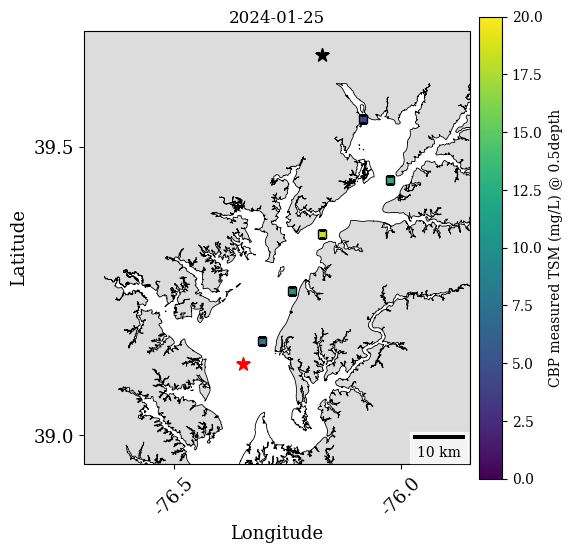

In [17]:
#The plot
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import Normalize
from matplotlib import rcParams
from matplotlib_scalebar.scalebar import ScaleBar

rcParams['font.family'] = 'serif'


fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('gainsboro')
shapefile_path = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_250m/Composite/Chesapeake_Bay_Shoreline_High_Resolution.shp'
gdf = gpd.read_file(shapefile_path)
gdf.boundary.plot(ax=ax, facecolor='white', edgecolor='black', alpha=1, linewidth=0.6 , zorder = 1)
#im = dsTSM['TSM'].plot(ax=ax, cmap='viridis', add_colorbar = True, vmin = 0, vmax = 200)
#Plot CBP locaitons
i = 0
for key in CBP_dict:
    norm = Normalize(vmin=CBP_dict[key]['TSM'].min(), vmax=CBP_dict[key]['TSM'].max())
    print(key)
    tempDf = CBP_dict[key]
    cropDf = tempDf[tempDf['Date'] == DOI] #Crop to DOI
    cropDf = cropDf[cropDf['(mg/L)'] == 0.5] #Crop to depth
    #print(CBP_coords['Location'][i])
    lat,lon = CBP_coords['lat'][i],CBP_coords['lon'][i]
    print(cropDf['TSM'].mean())
    TSM_value = float(cropDf['TSM'].mean())
    if str(cropDf['TSM'].mean()) !='nan':
        plt.scatter(lat, lon, c = TSM_value, label = key, s =40, linewidth = 1, cmap = 'viridis', edgecolor = 'black', marker = 's', vmin = 0 ,vmax = 20)
    else: print('NAN value - not added to plot')
    #print('\n')
    i=i+1
cbar = plt.colorbar(orientation='vertical', pad=0.02)
cbar.set_label('CBP measured TSM (mg/L) @ 0.5depth', fontsize=10)
# Plot Aeronet
aerlon = -76.34890 #aero
aerlat = 39.12351 #aero
plt.scatter(aerlon, aerlat, label = 'Aeronet', s = 100, c = 'red', marker = '*')

# Plot USGS Stream Gauge, SQ
USGSlon = -76.1744444
USGSlat = 39.65788889
plt.scatter(USGSlon, USGSlat, label = 'USGS SQ', s = 100, c = 'black', marker = '*')


#X and Y ticks
xticks = np.arange(-78, -75, 0.5)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_xticklabels(xticks, rotation=45, fontsize = 13)
yticks = np.arange(37, 40, 0.5)
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.set_yticklabels(yticks,fontsize = 13)
plt.title(str(DOI.date()))
plt.xlabel('Longitude', fontsize = 13)
plt.ylabel('Latitude', fontsize = 13)

latitude_center = (38.95 + 39.7) / 2  # Average latitude
meters_per_degree_longitude = np.cos(np.radians(latitude_center)) * 111320  # Convert to meters

# Add scale bar 
scalebar = ScaleBar(
    meters_per_degree_longitude,   
    units='m',                    
    location='lower right',       
    color='black',                
    length_fraction=0.2,          
    scale_loc='bottom',           
    box_alpha=0.7,                
)

ax.add_artist(scalebar)
#add_north_arrow(ax, scale=.22, xlim_pos=.5, ylim_pos=.94, color='#000', text_scaler=4, text_yT=-1.25)
latmin, latmax = 38.95, 39.7
plt.ylim(latmin, latmax)

plt.xlim(-76.7,-75.85)
#Show plot
#plt.legend()

#plt.savefig(f'/panfs/ccds02/nobackup/people/slsmit34/figs_for_aero_paper/CBP_map.png', dpi = 300)

plt.show()

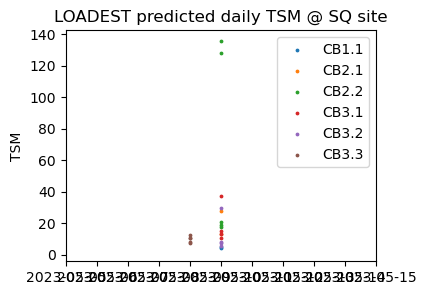

In [231]:
# Method for plotting TSM from the CB data
def plotTSM(key, param):
    df =  CBP_dict[key]
    plt.scatter(df['Date'], df[param], label = key, s = 3)
    return('done')

# Param of interest
param = 'TSM'

# Make the plot
plt.figure(figsize=(4,3))        
for CBP_key in CBP_dict: plotTSM(CBP_key, param)
plt.ylabel(param)
plt.title('CBP TSM')
plt.legend()

#xticks

plt.xlim(pd.to_datetime('5-5-2023'),pd.to_datetime('5-15-2023'))
plt.show()

#### 2. LOADEST predicted daily TSM (SQ) - Blake

---- Predicted TSM at SQ with LOADEST ----


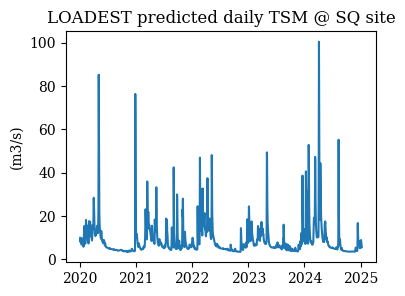

In [18]:
# Load in aeronet file
df_SQ_TSM_predicted = pd.read_csv('/panfs/ccds02/nobackup/people/slsmit34/Insitu/Blake_TSM/Susq_TSM_predicted_2020_2025.dat', delim_whitespace=True, header=0)
df_SQ_TSM_predicted['Date'] = pd.to_datetime(df_SQ_TSM_predicted['Date'], format='%d-%b-%Y')

#display contents
print(f"---- Predicted TSM at SQ with LOADEST ----")
df_SQ_TSM_predicted.head()
plt.figure(figsize=(4,3))
param = '(m3/s)'
plt.plot(df_SQ_TSM_predicted['Date'], df_SQ_TSM_predicted[param])
plt.ylabel(param)
plt.title('LOADEST predicted daily TSM @ SQ site')
plt.show()

#### Plot it

(A) With Satellite Data

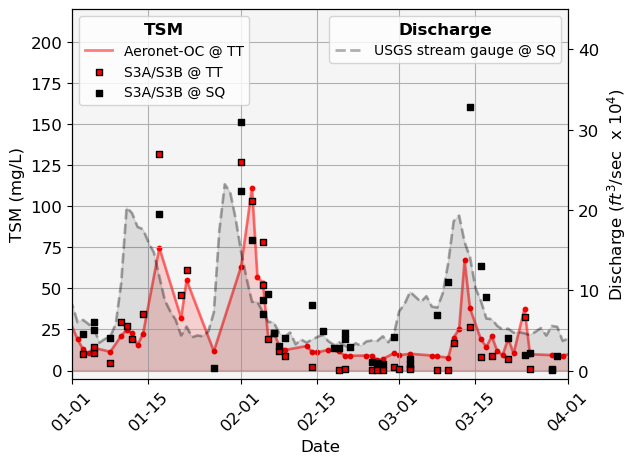

In [8]:
import matplotlib.dates as mdates
fig, ax1 = plt.subplots()  # Create figure and axis objects for the first y-axis
ax1.set_facecolor('whitesmoke')  # Set the axis face color
plt.grid(True)
#Add stream gauge data
wavelength = 645
ax2 = ax1.twinx()  # Create a second y-axis
#plot stream gauge
ax2.plot(df_stream['date'], df_stream['68118_00060_00003']/10000, color='black', alpha = 0.3,lw=2,linestyle = '--', label = 'USGS stream gauge @ SQ')  # Plot stream gauge data on the second y-axis
plt.fill_between(df_stream['date'], df_stream['68118_00060_00003']/10000, color='black', alpha=0.1, zorder = 0)

#plot df_aero
ax1.scatter(df_aero['date_dt'], df_aero['TSM'], c = 'red', s = 10)
ax1.plot(df_aero['date_dt'], df_aero['TSM'], lw=2, alpha = 0.5, c = 'red', label = 'Aeronet-OC @ TT')
ax1.fill_between(df_aero['date_dt'], df_aero['TSM'], color='red', alpha=0.15, zorder = 0)


#plot of df_tsm
ax1.scatter(dfAE['date'], dfAE['TSM'], c = 'r', edgecolors = 'black', marker = 's', s = 25, label = 'S3A/S3B @ TT', zorder = 2)
#ax1.plot(dfAE['date'], dfAE['TSM'], c = 'b')

ax1.scatter(dfSQ['date'], dfSQ['TSM'],marker = 's',  c = 'black', s = 25, label = 'S3A/S3B @ SQ', zorder = 2)
#ax1.plot(dfSQ['date'], dfSQ['TSM'], c = 'red', alpha = 0.6)

ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
#Set title font
from matplotlib.font_manager import FontProperties

# Create font properties with the desired size and style
title_font = FontProperties()
title_font.set_size(12)          # Adjust font size here
title_font.set_weight('bold')    # Optional: make the title bold
#title_font.set_style('italic')   # Optional: make the title italic


ax1_legend = ax1.legend(loc='upper left', fontsize=10, title="TSM")
ax2_legend = ax2.legend(loc='upper right', fontsize = 10, title = "Discharge")
ax2_legend.get_title().set_fontproperties(title_font)
ax1_legend.get_title().set_fontproperties(title_font)

ax1.set_ylabel('TSM (mg/L)', fontsize =12)
ax2.set_ylabel('Discharge ($ft^3$/sec  x $10^4$)', fontsize = 12)
#plt.title('TSM readings at Aeronet and SQ Sites', fontsize = 14)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlim(pd.to_datetime('2024-01-01'),pd.to_datetime('2024-04-01'))
ax1.set_ylim(-5, 220)
ax2.set_ylim(-1, 45)
ax1.set_xlabel("Date", fontsize = 12)
#
plt.show()

(B) With CBP Data

In [19]:
# datetime conversion
dfAE['datetime'] = dfAE['datetime_est'].apply(lambda x: pd.to_datetime(x).date())
dfSQ['datetime'] = pd.to_datetime(dfSQ['datetime'])

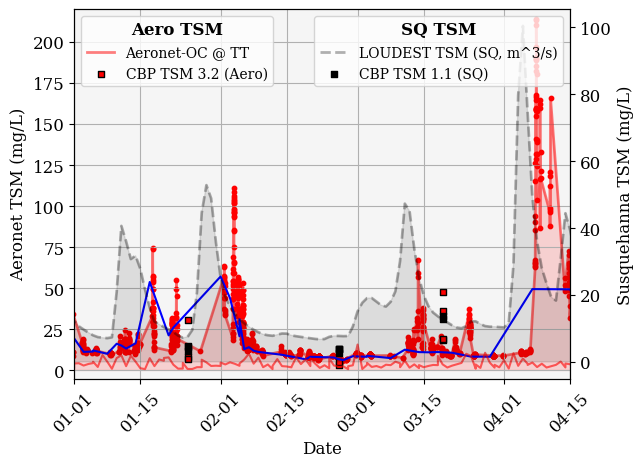

In [20]:
import matplotlib.dates as mdates
fig, ax1 = plt.subplots()  
ax1.set_facecolor('whitesmoke')  
plt.grid(True)
#Add stream gauge data
wavelength = 645
ax2 = ax1.twinx()  #twin axis!
#plot stream gauge
param = '(m3/s)'
ax2.plot(df_SQ_TSM_predicted['Date'], df_SQ_TSM_predicted[param], color='black', alpha = 0.3,lw=2,linestyle = '--', label = 'LOUDEST TSM (SQ, m^3/s)')  # Plot stream gauge data on the second y-axis
plt.fill_between(df_SQ_TSM_predicted['Date'], df_SQ_TSM_predicted[param], color='black', alpha=0.1, zorder = 0)

#plot df_aero
ax1.scatter(df_aero['datetime'], df_aero['TSM'], c = 'red', s = 10)
ax1.plot(df_aero['datetime'], df_aero['TSM'], lw=2, alpha = 0.5, c = 'red', label = 'Aeronet-OC @ TT')
ax1.fill_between(df_aero['datetime'], df_aero['TSM'], color='red', alpha=0.15, zorder = 0)


#plot of CBP TSM
ax1.scatter(CB3_2['Date'], CB3_2['TSM'], c = 'r', edgecolors = 'black', marker = 's', s = 25, label = 'CBP TSM 3.2 (Aero)', zorder = 2)
ax1.plot(dfAE['datetime'], dfAE['TSM'], c = 'b')

ax2.scatter(CB1_1['Date'], CB1_1['TSM'],marker = 's',  c = 'black', s = 25, label = 'CBP TSM 1.1 (SQ)', zorder = 2)
ax1.plot(dfSQ['datetime'], dfSQ['TSM'], c = 'red', alpha = 0.6)

ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
#Set title font
from matplotlib.font_manager import FontProperties

# font properties
title_font = FontProperties()
title_font.set_size(12)          
title_font.set_weight('bold')    
#title_font.set_style('italic')   


ax1_legend = ax1.legend(loc='upper left', fontsize=10, title="Aero TSM")
ax2_legend = ax2.legend(loc='upper right', fontsize = 10, title = "SQ TSM")
ax2_legend.get_title().set_fontproperties(title_font)
ax1_legend.get_title().set_fontproperties(title_font)

ax1.set_ylabel('Aeronet TSM (mg/L)', fontsize =12)
ax2.set_ylabel('Susquehanna TSM (mg/L)', fontsize = 12)
#plt.title('TSM readings at Aeronet and SQ Sites', fontsize = 14)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlim(pd.to_datetime('2024-01-01'),pd.to_datetime('2024-04-15'))
ax1.set_ylim(-5, 220)
#ax2.set_ylim(-1, 45)
ax1.set_xlabel("Date", fontsize = 12)
#
plt.show()

(2b) Scatterplot 3_2 vs Aeronet TSM

Aeronet points (2021-2024): 13326
CB3.2 points (2020-2025): 236
Merged points: 422


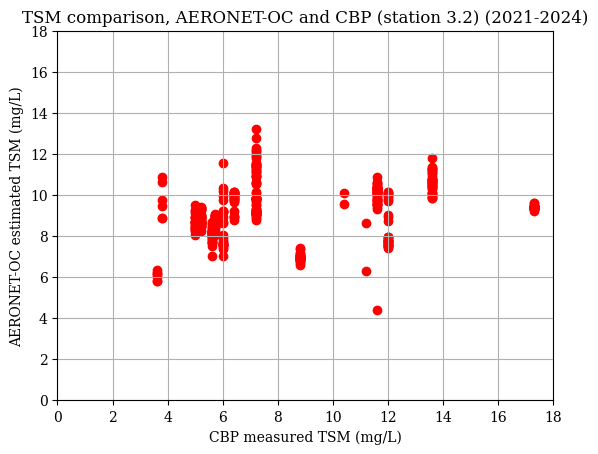

In [21]:
merged_CB_AE = CB3_2
merged_CB_AE = merged_CB_AE[merged_CB_AE['(mg/L)'] == 0.5]
try: 
    merged_CB_AE['date_dt'] = merged_CB_AE['Date']
    merged_CB_AE = pd.merge(merged_CB_AE, df_aero, on='date_dt')
except: 
    merged_CB_AE['date'] = merged_CB_AE['Date']
    merged_CB_AE = pd.merge(merged_CB_AE, df_aero, on='date')
print(f'Aeronet points (2021-2024): {len(df_aero)}')
print(f'CB3.2 points (2020-2025): {len(CB3_2)}')
print(f'Merged points: {len(merged_CB_AE)}')
plt.scatter(merged_CB_AE['TSM_x'], merged_CB_AE['TSM_y'], c = 'r')
plt.xlabel('CBP measured TSM (mg/L)')
plt.ylabel('AERONET-OC estimated TSM (mg/L)')
plt.grid()
plt.title('TSM comparison, AERONET-OC and CBP (station 3.2) (2021-2024)')
plt.xlim(0,18)
plt.ylim(0,18)
plt.show()

(2c) On 1 axis

In [22]:
#Get hourly average
import pandas as pd

# Extract hour
df_aero['hour'] = df_aero['datetime'].dt.floor('H')
df_aero
# Calc hourly avg TSM
hourly_avg = df_aero.groupby('hour')['TSM'].mean().reset_index()
hourly_max = df_aero.groupby('hour')['TSM'].max().reset_index()
daily_avg = df_aero.groupby('date')['TSM'].mean().reset_index()
daily_max = df_aero.groupby('date')['TSM'].max().reset_index()

hourly_avg.head()


,hour,TSM
0,2021-10-07 13:00:00,7.157048
1,2021-10-16 14:00:00,6.250263
2,2021-10-17 15:00:00,10.770806
3,2021-10-18 14:00:00,11.037005
4,2021-10-20 14:00:00,7.454872


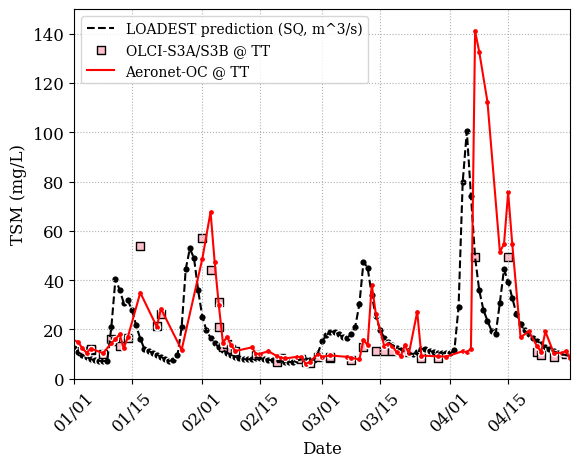

In [23]:
import matplotlib.dates as mdates
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
fig, ax1 = plt.subplots()  
#ax1.set_facecolor('whitesmoke')  # Set the axis face color
plt.grid(True, linestyle=':')
#Add stream gauge data
wavelength = 645
#plot stream gauge
param = '(m3/s)'
ax1.plot(df_SQ_TSM_predicted['Date'], df_SQ_TSM_predicted[param], color='black', alpha = 1,lw=1.5,linestyle = '--', label = 'LOADEST prediction (SQ, m^3/s)')  # Plot stream gauge data on the second y-axis
ax1.scatter(df_SQ_TSM_predicted['Date'], df_SQ_TSM_predicted[param],  facecolors = 'black', edgecolors ='white', s = 30, alpha = 1)  # Plot stream gauge data on the second y-axis
#plt.fill_between(df_SQ_TSM_predicted['Date'], df_SQ_TSM_predicted[param], color='black', alpha=0.1, zorder = 0)

# Add satellite data
dfAE['datetime'] = dfAE['datetime_est'].apply(lambda x: pd.to_datetime(x).date())
#dfSQ['datetime'] = pd.to_datetime(dfSQ['datetime'])
ax1.scatter(dfAE['datetime'], dfAE['TSM'], edgecolor = 'black', label = 'OLCI-S3A/S3B @ TT', facecolor = 'pink', marker = 's')
#ax1.scatter(dfSQ['datetime'], dfSQ['TSM'], edgecolor = 'g')


def plotAE_TSM(df_aero, colName):
    ax1.scatter(df_aero[colName], df_aero['TSM'], facecolors = 'red', edgecolors = 'white', s = 20)
    ax1.plot(df_aero[colName], df_aero['TSM'], lw=1.5, alpha = 1, c = 'red', label = 'Aeronet-OC @ TT')
    #ax1.fill_between(df_aero[colName], df_aero['TSM'], color='red', alpha=0.1, zorder = 0)

statToPlot = 'daily_avg' # hourly_avg, hourly_max, all
if statToPlot == 'all': 
    dfOI = df_aero
    colName = 'datetime'
elif statToPlot == 'hourly_avg': 
    dfOI = hourly_avg
    colName = 'hour'
elif statToPlot == 'hourly_max': 
    dfOI = hourly_max
    colName = 'hour'
elif statToPlot == 'daily_max': 
    dfOI = daily_max
    colName = 'date'
elif statToPlot == 'daily_avg': 
    dfOI = daily_avg
    colName = 'date'

plotAE_TSM(dfOI, colName)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
#Set title font
from matplotlib.font_manager import FontProperties
title_font = FontProperties()
title_font.set_size(12)          
title_font.set_weight('bold')    

ax1.set_ylabel('TSM (mg/L)', fontsize =12)
#plt.title('TSM readings at Aeronet and SQ Sites', fontsize = 14)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(pd.to_datetime('2024-01-01'),pd.to_datetime('2024-04-30'))
ax1.set_ylim(0, 150)
#ax2.set_ylim(-1, 45)
ax1.set_xlabel("Date", fontsize = 12)
plt.legend(loc = 'upper left')
#
plt.show()

(2d) Diurnal Variability

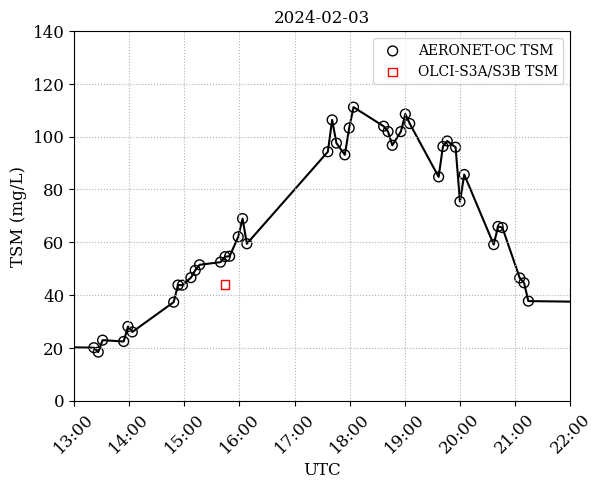

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

wavelength = 645
rcParams['font.family'] = 'serif'
df_aero['datetime'] = pd.to_datetime(df_aero['datetime'], utc=True)
df_aero['datetime_est'] = df_aero['datetime'].dt.tz_convert('US/Eastern')

# create fig
fig, ax1 = plt.subplots()
plt.grid(True, linestyle=':')


# Plot data
ax1.scatter(df_aero['datetime_est'], df_aero['TSM'], facecolors='none', edgecolors='black', s=50, alpha=1, label='AERONET-OC TSM',zorder = 1)
ax1.plot(df_aero['datetime_est'], df_aero['TSM'], lw=1.5, alpha=1, c='black', zorder = 0)
ax1.scatter(dfAE['datetime_est'], dfAE['TSM'], edgecolor = 'r', marker = 's', facecolor = 'none', label = 'OLCI-S3A/S3B TSM')


# Format
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylabel('TSM (mg/L)', fontsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
DayStart = '2024-02-03'
DayEnd = '2024-02-03'
plt.xlim(pd.to_datetime(f'{DayStart} 1:00:00 PM'), pd.to_datetime(f'{DayEnd} 10:00:00 PM'))
ax1.set_ylim(0, 140)
ax1.set_xlabel('UTC', fontsize=12)
plt.title(DayStart)
plt.legend()
output = f'/panfs/ccds02/nobackup/people/slsmit34/figs_for_aero_paper/{DayStart}_TSM.png'
plt.savefig(output, dpi=600, bbox_inches='tight')


plt.show()

### Cross Correlation Lag Analysis

In [1]:
import matplotlib.dates as mdates
fig, ax1 = plt.subplots()  # Create figure and axis objects for the first y-axis
ax1.set_facecolor('whitesmoke')  # Set the axis face color
plt.grid(True)
#Add stream gauge data
wavelength = 645
ax2 = ax1.twinx()  # Create a second y-axis
#plot stream gauge
ax2.plot(df_stream['date'], df_stream['68118_00060_00003']/10000, color='black', alpha = 0.3,lw=2,linestyle = '--', label = 'USGS stream gauge @ SQ')  # Plot stream gauge data on the second y-axis
plt.fill_between(df_stream['date'], df_stream['68118_00060_00003']/10000, color='black', alpha=0.1, zorder = 0)

#plot df_aero
ax1.scatter(df_aero['datetime'], df_aero['TSM'], c = 'red', s = 10)
ax1.plot(df_aero['datetime'], df_aero['TSM'], lw=2, alpha = 0.5, c = 'red', label = 'Aeronet-OC @ TT')
ax1.fill_between(df_aero['datetime'], df_aero['TSM'], color='red', alpha=0.15, zorder = 0)


ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
#Set title font
from matplotlib.font_manager import FontProperties

# Create font properties with the desired size and style
title_font = FontProperties()
title_font.set_size(12)          # Adjust font size here
title_font.set_weight('bold')    # Optional: make the title bold
#title_font.set_style('italic')   # Optional: make the title italic


ax1_legend = ax1.legend(loc='upper left', fontsize=10, title="TSM")
ax2_legend = ax2.legend(loc='upper right', fontsize = 10, title = "Discharge")
ax2_legend.get_title().set_fontproperties(title_font)
ax1_legend.get_title().set_fontproperties(title_font)

ax1.set_ylabel('TSM (mg/L)', fontsize =12)
ax2.set_ylabel('Discharge ($ft^3$/sec  x $10^4$)', fontsize = 12)
#plt.title('TSM readings at Aeronet and SQ Sites', fontsize = 14)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xlim(pd.to_datetime('2024-01-01'),pd.to_datetime('2024-04-01'))
ax1.set_ylim(-5, 220)
ax2.set_ylim(-1, 45)
ax1.set_xlabel("Date", fontsize = 12)
#
print('Original Trend:   ')
plt.show()

NameError: name 'plt' is not defined

#### Use scipy for cross cor analysis

---- Predicted TSM at SQ with LOADEST ----


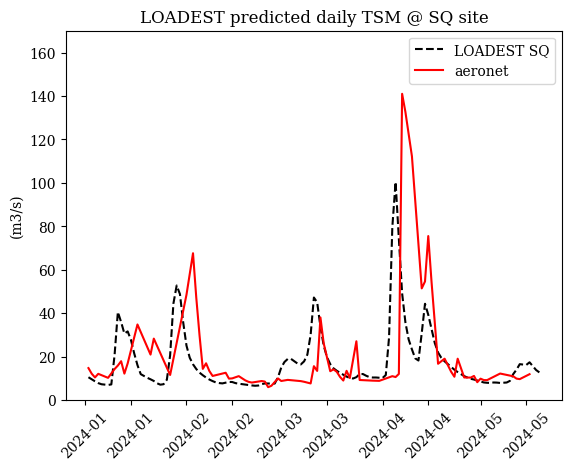

In [41]:
# Load in aeronet file (TSM) from insitu directory
df_SQ_TSM_predicted = pd.read_csv('/panfs/ccds02/nobackup/people/slsmit34/Insitu/Blake_TSM/Susq_TSM_predicted_2020_2025.dat', delim_whitespace=True, header=0)
df_SQ_TSM_predicted['Date'] = pd.to_datetime(df_SQ_TSM_predicted['Date'], format='%d-%b-%Y')
df_aero['Date'] = df_aero['datetime']
df_SQ_TSM_predicted['TSM'] = df_SQ_TSM_predicted['(m3/s)']
#display contents
print(f"---- Predicted TSM at SQ with LOADEST ----")
df_SQ_TSM_predicted.head()

#Crop to 4 months (OMIT THIS to do for entire time series)
def cropToTime(df):
    startDate = '2024-01-01'
    finDate = '2024-05-20'
    try:
        df = df[df['Date'] > pd.to_datetime(startDate)]
        df = df[df['Date'] < pd.to_datetime(finDate)]
    except:
        df = df[df['date'] > pd.to_datetime(startDate)]
        df = df[df['date'] < pd.to_datetime(finDate)]
    return(df)
df_aero = cropToTime(df_aero)
daily_avg = cropToTime(daily_avg)
daily_max = cropToTime(daily_max)
df_SQ_TSM_predicted = cropToTime(df_SQ_TSM_predicted)

#Plot it 
fig, ax1 = plt.subplots()  # Create figure and axis objects for the first y-axis
ax1.tick_params(axis='x', rotation=45)

param = '(m3/s)'
plt.plot(df_SQ_TSM_predicted['Date'], df_SQ_TSM_predicted[param], c = 'black', linestyle = 'dashed',label = 'LOADEST SQ')

#Three options to plot aeronet data
#plt.plot(df_aero['datetime'], df_aero['TSM'], c = 'g')
#plt.plot(daily_avg['date'], daily_avg['TSM'], c = 'r', label = 'aeronet')
plt.plot(daily_avg['date'], daily_avg['TSM'], c = 'r', label = 'aeronet')

plt.ylabel(param)
plt.ylim(0,170)
#plt.xlim(pd.to_datetime('2022-05-13'), pd.to_datetime('2024-12-31'))
plt.title('LOADEST predicted daily TSM @ SQ site')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.legend()
plt.show()


In [42]:
df_SQ_TSM_predicted_max = df_SQ_TSM_predicted[df_SQ_TSM_predicted['(m3/s)']>35]
df_SQ_TSM_predicted_max

,Date,Q,(m3/s),Conc,(mg/L),Mass,(kg/d),TSM
1471,2024-01-11,4983.8,40.651,17504000.0,NaN,NaN,NaN,40.651
1472,2024-01-12,4559.0,36.009,14184000.0,NaN,NaN,NaN,36.009
1488,2024-01-28,5068.7,44.509,19492000.0,NaN,NaN,NaN,44.509
1489,2024-01-29,5691.7,52.833,25981000.0,NaN,NaN,NaN,52.833
1490,2024-01-30,5380.2,48.880,22722000.0,NaN,NaN,NaN,48.880
1491,2024-01-31,4304.2,35.853,13333000.0,NaN,NaN,NaN,35.853
1531,2024-03-11,4700.6,47.302,19211000.0,NaN,NaN,NaN,47.302
1532,2024-03-12,4530.7,45.089,17650000.0,NaN,NaN,NaN,45.089
1555,2024-04-04,6427.9,79.685,44255000.0,NaN,NaN,NaN,79.685
1556,2024-04-05,7475.6,100.460,64889000.0,NaN,NaN,NaN,100.460


In [43]:
daily_avg['Date'] = daily_avg['date']
daily_max['Date'] = daily_max['date']

Maximum correlation of 0.814 occurs at lag: 3 days


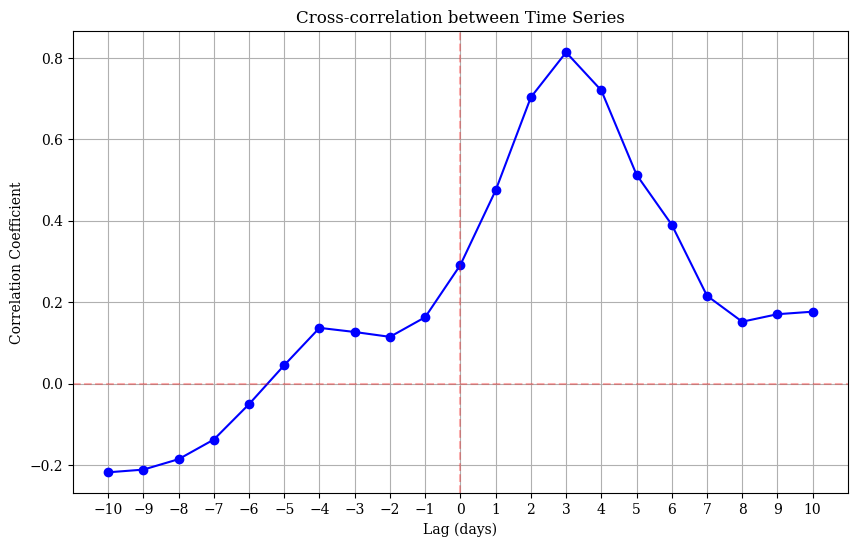


Correlation values for all lags:
    Lag (days)  Correlation
0          -10    -0.217398
1           -9    -0.210786
2           -8    -0.185164
3           -7    -0.136980
4           -6    -0.050043
5           -5     0.045714
6           -4     0.137348
7           -3     0.127193
8           -2     0.115288
9           -1     0.163541
10           0     0.291960
11           1     0.474891
12           2     0.703578
13           3     0.814031
14           4     0.720521
15           5     0.513438
16           6     0.390546
17           7     0.216176
18           8     0.152451
19           9     0.170892
20          10     0.177075


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dfForAnalysis = daily_avg
try:
    df_SQ_TSM_predicted['Date'] = pd.to_datetime(df_SQ_TSM_predicted['Date'])
except: pass;
dfForAnalysis['Date'] = pd.to_datetime(dfForAnalysis['Date'])

# set date as index
try:
    df_SQ_TSM_predicted = df_SQ_TSM_predicted.set_index('Date')
except:
    print('passed')
    
dfForAnalysis = dfForAnalysis.set_index('Date')

# match frequency
df1 = df_SQ_TSM_predicted['TSM'].resample('D').mean()
df2 = dfForAnalysis['TSM'].resample('D').mean()

# Remove Nnan
df1 = df1.dropna()
df2 = df2.dropna()

# corss cor up to 10 days
max_lag = 10
correlations = []
lags = range(-max_lag, max_lag + 1)

for lag in lags:
    if lag < 0:
        correlation = df1.corr(df2.shift(abs(lag)))
    else:
        correlation = df1.shift(lag).corr(df2)
    correlations.append(correlation)

#formatting...
correlations = np.array(correlations)
optimal_lag = lags[np.argmax(correlations)]
max_correlation = np.max(correlations)

print(f"Maximum correlation of {max_correlation:.3f} occurs at lag: {optimal_lag} days")

#  results
plt.figure(figsize=(10, 6))
plt.plot(lags, correlations, 'b-', marker='o')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.xlabel('Lag (days)')
plt.ylabel('Correlation Coefficient')
plt.title('Cross-correlation between Time Series')
plt.grid(True)
plt.xticks(lags)
plt.show()


lag_corr_df = pd.DataFrame({
    'Lag (days)': lags,
    'Correlation': correlations
})
print("\nCorrelation values for all lags:")
print(lag_corr_df)

Maximum correlation of 0.814 occurs at lag: 3 days


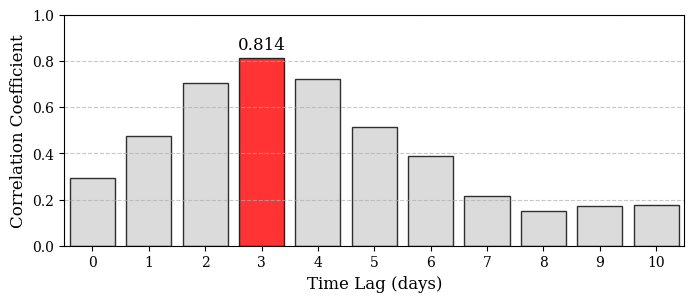


Correlation values for all lags:
    Lag (days)  Correlation
0          -10    -0.217398
1           -9    -0.210786
2           -8    -0.185164
3           -7    -0.136980
4           -6    -0.050043
5           -5     0.045714
6           -4     0.137348
7           -3     0.127193
8           -2     0.115288
9           -1     0.163541
10           0     0.291960
11           1     0.474891
12           2     0.703578
13           3     0.814031
14           4     0.720521
15           5     0.513438
16           6     0.390546
17           7     0.216176
18           8     0.152451
19           9     0.170892
20          10     0.177075


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(f"Maximum correlation of {max_correlation:.3f} occurs at lag: {optimal_lag} days")

#make fig
colors = ['lightGray' if lag != optimal_lag else 'red' for lag in lags]
plt.figure(figsize=(8,3))
plt.bar(lags, correlations, color=colors, edgecolor='black', alpha=0.8)
plt.text(optimal_lag, max_correlation + 0.02, f"{max_correlation:.3f}", 
         ha='center', va='bottom', fontsize=12, color='black')

# Plot 
plt.xlabel("Time Lag (days)", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# set x axis to days studied
ticks = np.arange(-max_lag, max_lag + 1, 1)
plt.xticks(ticks)
plt.xlim(-.5, 10.5)
plt.ylim(0, 1)  
output = f'/panfs/ccds02/nobackup/people/slsmit34/figs_for_aero_paper/crossCor.png'
plt.savefig(output, dpi=600, bbox_inches='tight')

plt.show()


lag_corr_df = pd.DataFrame({
    'Lag (days)': lags,
    'Correlation': correlations
})
print("\nCorrelation values for all lags:")

print(lag_corr_df)